# Libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm
from scipy.spatial import ConvexHull
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

### The Standard Vicsek Model

The Standard Vicsel Model (SVM) is a simple statistical physical approach that aims to simulate to collective motion of animals. Each unit / individual in the system:
- move with a fixed absolute velocity $(v_{0})$
- assume the average direction of others within a given distance $R$, also called the *Range of Interaction*

Perturbations are taken into account by adding a random angle to the average direction from a uniform distribition between the interval $[-\eta/2, \eta/2]$, where $\eta$ is the level of perturbation. By taking all these into account we can determine the motion of unit $i$ the following way:

$$\vartheta (t + 1) = \braket{\vartheta(t)} + \xi,$$

where $t$ is the time and $\xi$ is the noise. 

In order to determine whether the units are moving in a ordered or disordered fashion we calculate the *Order Parameter*:

$$\varphi = \frac{1}{N\cdot v_{0}} \left|\sum_{i = 1}^{N}\vec{v_i}\right|,$$

which is Non-zero in the ordered phase and Zero in the disordered phase.

### The model extansion

This model aims to implement the Standard Vicsek Model and also extend it. This extansion is done through the intorduiction of *social graphs* into the system. This means that the units wihtin the system have relationships between each other. Two units are either:
- relatied to each other
- isn't related to each other.

If two untis are in each others *Range of Interaction* they will influence each others angle more than units that they are not related too.

# Functions

In [2]:
# The collection of functions used for the simulations

def GeneratePoints(n = int, square_size=5):
    """ Generates the initial positions and angles of the units in the simulation. """
    points = np.random.rand(n, 2) * square_size
    angles = np.random.uniform(0, 2 * np.pi, n)
    return points, angles

def CreateGraph(points = np.array, edge_count = int, connected = True):
    """Creates the social graph of the units based on coordinates and the number of edges in the graph. Returns both the graph and a list of connections"""
    # Initialize a MultiGraph
    G = nx.MultiGraph()
    

    # Add nodes with positions as attributes
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))
    
    if connected == True:
        # First, create a spanning tree to ensure the graph is connected
        G.add_edges_from(nx.minimum_spanning_tree(nx.Graph(G)).edges())

        # Add random edges to reach the desired edge count
        while len(G.edges()) < edge_count:
            u, v = np.random.choice(len(points), 2, replace=False)
            # Ensure no self-loop and edge does not already exist
            if u != v and not G.has_edge(u, v):
                G.add_edge(u, v)

    else:

        # Randomly add edges
        for _ in range(edge_count):
            u, v = np.random.choice(len(points), 2, replace=False)
            G.add_edge(u, v)
        
    # Collect connections into adjacency list format
    adjacency_list = defaultdict(list)
    for u, v in G.edges():
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)  # Add both directions for undirected graph
    
    # Convert defaultdict to a regular list of lists for output
    result = [adjacency_list[i] for i in range(len(points))]
    
    return G, result

def PlotGraph(G):
    """Plots the social graph"""
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=80, font_size=10)
    plt.show()

def RecreateGraph(positions, adjacency_list):
    """
    Recreates a graph using the positions (numpy array) and adjacency list.
    
    INPUT:
        positions (numpy array): 2D numpy array of (x, y) positions for the nodes.
        adjacency_list (list of lists): Adjacency list where each sublist contains connected nodes.
    
    OUTPUT:
        G (NetworkX graph): The recreated graph.
    """
    # Initialize the graph
    G = nx.Graph()
    
    # Add nodes with positions (from the numpy array)
    for i, (x, y) in enumerate(positions):
        G.add_node(i, pos=(x, y))
    
    # Add edges based on adjacency list
    for i, neighbors in enumerate(adjacency_list):
        for neighbor in neighbors:
            # Avoid duplicate edges by only adding when i < neighbor
            if i < neighbor:
                G.add_edge(i, neighbor)
    
    return G

def OrderParameter(angle_history, velocity_magnitude):
    """
    Calculate the value of φ (phi) based on the given angle history and velocity magnitude.
    
    INPUT:
        angle_history (list): A list of angles (in radians).
        velocity_magnitude (float): The magnitude of each velocity vector.
        N (int): The number of velocity vectors (should be the length of angle_history).
    
    OUTPUT:
        float: The value of φ.
    """
    # Initialize components for the sum
    sum_vx = 0
    sum_vy = 0
    
    # Iterate through each angle in the history to calculate the components of velocity vectors
    for angle in angle_history:
        vx = velocity_magnitude * np.cos(angle)
        vy = velocity_magnitude * np.sin(angle)
        
        sum_vx += vx
        sum_vy += vy
    
    # Calculate the magnitude of the resultant vector
    resultant_magnitude = np.sqrt(sum_vx**2 + sum_vy**2)
    
    # Calculate φ (phi) based on the formula
    phi = resultant_magnitude / (N * velocity_magnitude)
    
    return phi

def Clustering(positions):
    """Performs the DBSCAN clustering algoruthm on a set of coordinates"""

    dbscan = DBSCAN(eps=2, min_samples=2)  # Adjust parameters as needed
    labels = dbscan.fit_predict(positions)

    # Extract results
    num_clusters = len(set(labels) - {-1})  # Exclude noise (-1)
    cluster_sizes = [list(labels).count(i) for i in set(labels) if i != -1]
    average_cluster_size = np.average(cluster_sizes)

    return  labels, num_clusters, average_cluster_size

def ClusteringAnalysis(positions_history):
    """Performs the DBSCAN clustering algoruthm on the results of a Simulation"""

    labels = []
    cluster_numbers = []
    cluster_sizes  = []

    for positions in positions_history:
        l, nc, cs = Clustering(positions)
        labels.append(l)
        cluster_numbers.append(nc)
        cluster_sizes.append(cs)

    return np.average(cluster_numbers), np.average(cluster_sizes)


def Update(positions = np.array, angles = np.array, relative_weight = float, relatives = list, eta = float):
    """Update function that calculates the new angle of each unit at each time step
    
    INPUT:
    - positions: Numpy array containing the coordinates of each unit at time step t
    - angles: Numpy array containing the angle of each units velocity vector at time step t.
    
    OUTPUT:
    - new_positions: Numpy array containing the coordinates of each unit at time step t + 1
    - new_angles: Numpy array containing the angle of each units velocity vector at time step t + 1
    """

    new_positions = positions.copy()
    new_angles = angles.copy()

    for i in range(N):
        # Computing the relative distance between unit i and other units
        distances = np.linalg.norm(positions - positions[i], axis = 1)
        neighbors = distances < r

        # Computing the average angle of particle i and its neighbours (including itself)
        vx_sum , vy_sum = 0, 0
        for j in range(N):
            if neighbors[j] == True:
                weight = relative_weight if j in relatives[i] else 1.0
                vx_sum  += weight * np.cos(angles[j])
                vy_sum  += weight * np.sin(angles[j])

        avg_angle = np.arctan2(vy_sum, vx_sum)

        # Update angle with added noise
        new_angles[i] = avg_angle + eta * np.random.uniform(-np.pi, np.pi)

    # Update positions based on new angles
    new_positions[:, 0] += v * np.cos(new_angles) * dt
    new_positions[:, 1] += v * np.sin(new_angles) * dt

    # Enforce periodic boundary conditions
    new_positions %= L

    return new_positions, new_angles

def Simulation(steps = int, eta = float, positions = list, angles = list, relative_weight = float, relatives = list):
    """Runs the Vicsek Model Simulation"""

    positions_history = [positions]
    angles_history = [angles]
    order_parameters = []

    for _ in range(steps):
        positions, angles = Update(positions, angles, relative_weight, relatives, eta)
        positions_history.append(positions)
        angles_history.append(angles)
    order_parameter = OrderParameter(angles_history[-1], v)
        #order_parameters.append(OrderParameter(angles, v))

    return positions_history, angles_history, order_parameter # np.average(order_parameters) 

def NoiseSimulation(steps, eta, positions, angles, relative_weight, relatives):
    """Runs the Vicsek Model Simulation at different noise levels."""

    order_parameter = []
    order_parameter_std = []
    cluster_numbers = []
    cluster_numbers_std = []
    cluster_sizes = []
    cluster_sizes_std = []

    for e in tqdm(eta):
        print("\r{}".format(e), end = "")
        temp = []
        temp2 = []
        temp3 = []
        for i in range(10):
            ph, ah, op = Simulation(steps, e, positions, angles, relative_weight, relatives)
            cn, cz = ClusteringAnalysis(ph)
            temp.append(op)
            temp2.append(cn)
            temp3.append(cz)
        order_parameter.append(np.average(temp))
        order_parameter_std.append(np.std(temp))
        cluster_numbers.append(np.average(temp2))
        cluster_numbers_std.append(np.std(temp2))
        cluster_sizes.append(np.average(temp3))
        cluster_sizes_std.append(np.std(temp3))

    return  order_parameter, order_parameter_std, cluster_numbers, cluster_numbers_std, cluster_sizes, cluster_sizes_std

def RelativeSimulations(steps, eta, positions, angles, relative_weights, relatives):
    """Runs the Vicsek Model Simulation at different relative weights."""

    order_parameter = []
    order_parameter_std = []
    cluster_numbers =  []
    cluster_numbers_std = []
    cluster_sizes = []
    cluster_sizes_std = []

    for rw in tqdm(relative_weights):
        print("\r{}".format(rw), end = "")
        temp = []
        temp2 = []
        temp3 = []
        for i in range(10):
            ph, ah, op = Simulation(steps, eta, positions, angles, rw, relatives)
            cn, cz = ClusteringAnalysis(ph)
            temp.append(op)
            temp2.append(cn)
            temp3.append(cz)
        order_parameter.append(np.average(temp))
        order_parameter_std.append(np.std(temp))
        cluster_numbers.append(np.average(temp2))
        cluster_numbers_std.append(np.std(temp2))
        cluster_sizes.append(np.average(temp3))
        cluster_sizes_std.append(np.std(temp3))

    return  order_parameter, order_parameter_std, cluster_numbers, cluster_numbers_std, cluster_sizes, cluster_sizes_std

def ClusterPlotter(positions):
    """Plots the resullt of a clustering"""

    labels, num_clusters, averages = Clustering(positions)

    for cluster in set(labels):
        if cluster == -1:
            color = 'k'  # Noise points
        else:
            color = plt.cm.jet(cluster / num_clusters)
        plt.scatter(positions[labels == cluster, 0], positions[labels == cluster, 1], color=color, label=f'Cluster {cluster}')
        plt.legend()
        plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
        plt.minorticks_on()
        plt.xlabel("x", fontdict=font2)
        plt.ylabel("y", fontdict=font2)

def GraphAnimation(graph, position_history, title, color1, color2):
    """Animates the movement of units"""

    fig, ax = plt.subplots()
    ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.4)  # Add a semi-transparent grid
    ax.set_xticks(range(0, L+1, 1))  # Set major x-axis ticks
    ax.set_yticks(range(0, L+1, 1))  # Set major y-axis ticks
    ax.set_xticks(np.arange(0, L+1, 0.5), minor=True)  # Minor x-axis ticks
    ax.set_yticks(np.arange(0, L+1, 0.5), minor=True)  # Minor y-axis ticks

    # Draw the graph initially
    nodes = nx.draw_networkx_nodes(graph, position_history[0], ax=ax, node_size=500, node_color=color1)
    edges = nx.draw_networkx_edges(graph, position_history[0], ax=ax, edge_color=color2)
    labels = nx.draw_networkx_labels(graph, position_history[0], ax=ax, font_size=12)

    # Function to update the graph for each frame in the animation
    def update(frame):
        ax.clear()  # Clear the previous frame
        positions = position_history[frame]  # Get the new positions for this frame
        
        # Redraw the graph with updated positions
        nx.draw_networkx_nodes(graph, positions, ax=ax, node_size=20, node_color=color1)
        nx.draw_networkx_edges(graph, positions, ax=ax, edge_color=color2, alpha=0.2)
        nx.draw_networkx_labels(graph, positions, ax=ax, font_size=0)
        
        ax.set_xlabel(f"Graph Animation - Frame {frame + 1}")
        ax.set_xlim(0, L)  # Set x and y axis limits
        ax.set_ylim(0, L)
        ax.set_title(f"{title}")
        
        ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.4)
        ax.set_xticks(range(0, L+1, 1))  # Major x-axis ticks
        ax.set_yticks(range(0, L+1, 1))  # Major y-axis ticks
        ax.set_xticks(np.arange(0, L+1, 0.5), minor=True)  # Minor x-axis ticks
        ax.set_yticks(np.arange(0, L+1, 0.5), minor=True)  # Minor y-axis ticks

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(position_history), interval=500, repeat=False)
    ani.save(f"{title}.gif", writer="ffmpeg", fps=20)

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}

# Simulations

In [3]:
# Parameters of the simulation

N = 150                         # Number of individuals
edge_count = 100                # Number of edges in the social graph
L = 10                          # Size of the square domain
v = 0.1                         # Speed of individuals
eta = np.linspace(0,0.8,20)       # Noise amplitude
r = 1.0                         # Interaction radius
relative_weight = 100.0           # Weight of relatives in angle computation
dt = 1.0                        # Time step
steps = 100                     # Number of simulation steps

In [ ]:
# Pregenerating the social graphs used in the simulation

positions, angles = GeneratePoints(N, square_size = L)

social_graph0, relatives0 = CreateGraph(positions, edge_count = 0, connected=False)
social_graph_parse, relatives_parse = CreateGraph(positions, edge_count = N, connected= False)
social_graph_dense, relatives_dense = CreateGraph(positions, edge_count = N**2, connected= False)

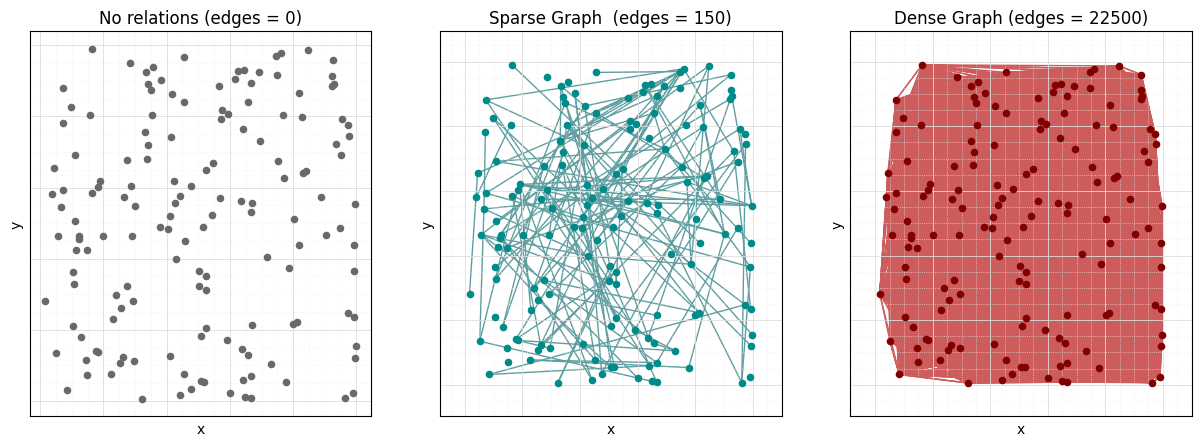

In [16]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
nx.draw_networkx(social_graph0, positions, node_size = 20, with_labels= False, node_color = "dimgrey", edge_color = "dimgrey")
plt.xlabel("x")
plt.ylabel("y")
plt.title("No relations (edges = 0)")
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.subplot(1,3,2)
nx.draw_networkx(social_graph_parse, positions, node_size = 20, with_labels= False, node_color = "darkcyan", edge_color = "cadetblue")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Sparse Graph  (edges = {N})")
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.subplot(1,3,3)
nx.draw_networkx(social_graph_dense, positions, node_size = 20, with_labels= False, node_color = "maroon", edge_color = "indianred")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Dense Graph (edges = {N**2})")
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()

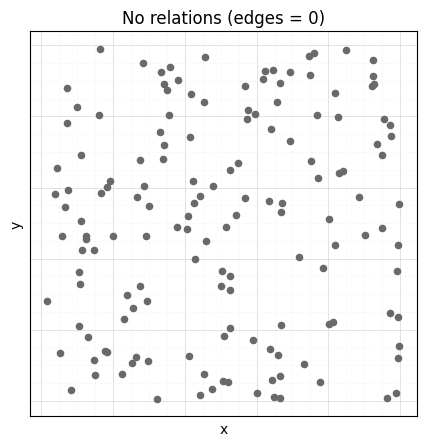

In [17]:
plt.figure(figsize=(5,5))
nx.draw_networkx(social_graph0, positions, node_size = 20, with_labels= False, node_color = "dimgrey", edge_color = "dimgrey")
plt.xlabel("x")
plt.ylabel("y")
plt.title("No relations (edges = 0)")
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()

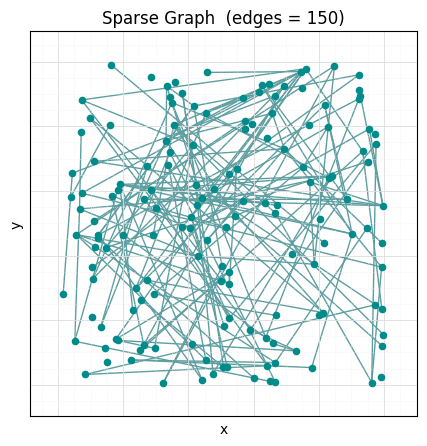

In [18]:
plt.figure(figsize=(5,5))
nx.draw_networkx(social_graph_parse, positions, node_size = 20, with_labels= False, node_color = "darkcyan", edge_color = "cadetblue")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Sparse Graph  (edges = {N})")
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()

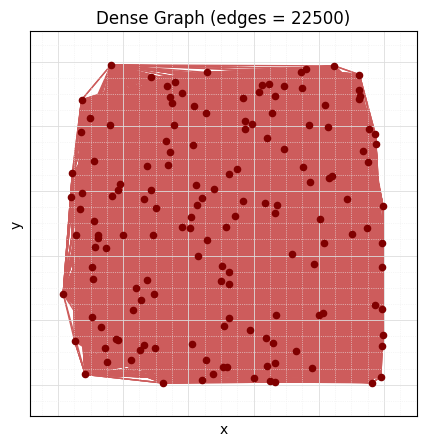

In [19]:
plt.figure(figsize=(5,5))
nx.draw_networkx(social_graph_dense, positions, node_size = 20, with_labels= False, node_color = "maroon", edge_color = "indianred")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Dense Graph (edges = {N**2})")
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()

# Noise Simulations

Testing how the system behaves at different noise levels.

In [8]:
op_0, op_0_std, cn_0, cn_0_std, cs_0, cs_0_std = NoiseSimulation(steps, eta, positions, angles, relative_weight, relatives0)
op_sparse, op_sparse_std, cn_sparse, cn_sparse_std, cs_sparse, cs_sparse_std = NoiseSimulation(steps, eta, positions, angles, relative_weight, relatives_parse)
op_dense, op_dense_std, cn_dense, cn_dense_std, cs_dense, cs_desns_std = NoiseSimulation(steps, eta, positions, angles, relative_weight, relatives_dense)

  0%|          | 0/20 [00:00<?, ?it/s]

0.857894736842105356

  0%|          | 0/20 [00:00<?, ?it/s]

0.857894736842105356

  0%|          | 0/20 [00:00<?, ?it/s]

0.857894736842105356

Text(0.045, 0.08, '\n N = 150 \n L = 10.00 \n ROI = 1.00 \n rw = 100')

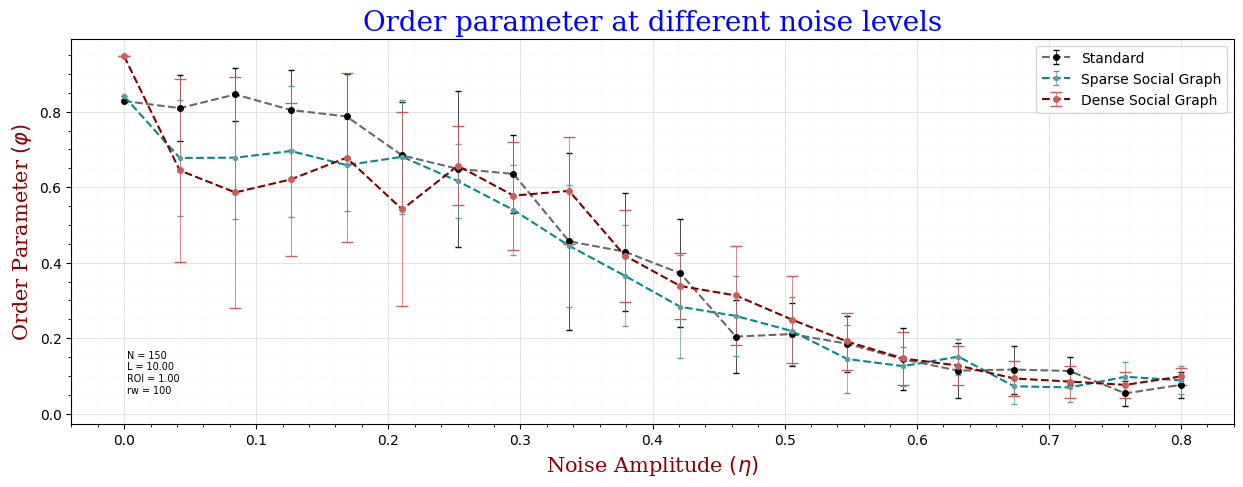

In [9]:
# Displaying the change of the order parameter of the different systems based on the change of the noise

plt.figure(figsize=(15,5))
plt.errorbar(eta, op_0, yerr=op_0_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=2, color = "dimgray", mec = 'black', ecolor="black", mfc = 'black', label = "Standard")
plt.errorbar(eta, op_sparse, yerr=op_sparse_std, marker = "o", ls = "--",  elinewidth=0.5, capsize=2, markersize = 3, ecolor = 'cadetblue', color = "darkcyan", mec = 'cadetblue', mfc = 'cadetblue', label = "Sparse Social Graph")
plt.errorbar(eta, op_dense, yerr=op_dense_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=4, ecolor="indianred", color = "maroon", mec = 'indianred', mfc = 'indianred', label = "Dense Social Graph")
plt.legend()
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title("Order parameter at different noise levels", fontdict=font1)
plt.xlabel("Noise Amplitude $(\\eta)$", fontdict=font2)
plt.ylabel("Order Parameter $(\\varphi)$", fontdict=font2)
plt.annotate('\n N = %d \n L = %.2f \n ROI = %.2f \n rw = %d' % (N, L, r, relative_weight), xy=(0.045, 0.08), xycoords='axes fraction', fontsize= 'x-small')

Text(0.5, 0.98, 'Cluster Analysis of Noise Levels')

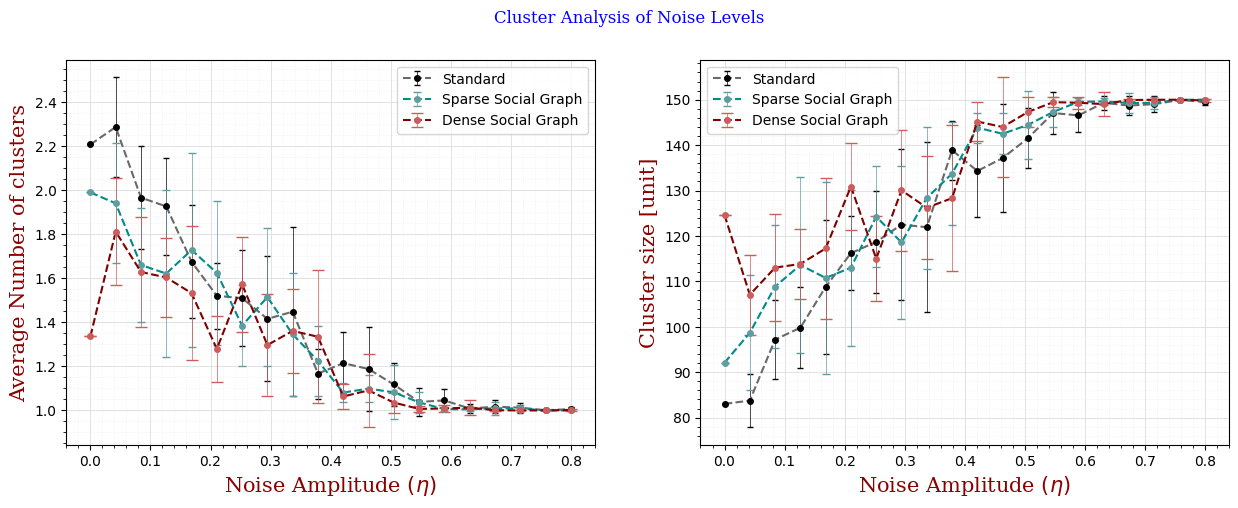

In [10]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.errorbar(eta, cn_0, yerr=cn_0_std, marker = "o", ls = "--",  elinewidth=0.5, capsize=2,  markersize = 4, ecolor="black", color = "dimgray", mec = 'black', mfc = 'black', label = "Standard")
plt.errorbar(eta, cn_sparse, yerr=cn_sparse_std, marker = "o",  elinewidth=0.5, capsize=3,  ls = "--", markersize = 4, ecolor="cadetblue", color = "darkcyan", mec = 'cadetblue', mfc = 'cadetblue', label = "Sparse Social Graph")
plt.errorbar(eta, cn_dense, yerr=cn_dense_std, marker = "o",  elinewidth=0.5, capsize=4,  ls = "--", markersize = 4, ecolor="indianred", color = "maroon", mec = 'indianred', mfc = 'indianred', label = "Dense Social Graph")
plt.legend()
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.xlabel("Noise Amplitude $(\\eta)$", fontdict=font2)
plt.ylabel("Average Number of clusters", fontdict=font2)
plt.subplot(1,2,2)
plt.errorbar(eta, cs_0, yerr=cs_0_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=2, ecolor="black", color = "dimgray", mec = 'black', mfc = 'black', label = "Standard")
plt.errorbar(eta, cs_sparse, yerr=cs_sparse_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=3, ecolor="cadetblue", color = "darkcyan", mec = 'cadetblue', mfc = 'cadetblue', label = "Sparse Social Graph")
plt.errorbar(eta, cs_dense, yerr=cs_desns_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=4, ecolor="indianred", color = "maroon", mec = 'indianred', mfc = 'indianred', label = "Dense Social Graph")
plt.legend()
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.xlabel("Noise Amplitude $(\\eta)$", fontdict=font2)
plt.ylabel("Cluster size [unit]", fontdict=font2)

fig.suptitle("Cluster Analysis of Noise Levels", fontdict = font1)

# Relative Strenght Simulations

Testing how different relative weights influence the behaviour of the system at a fix noise levels.

In [11]:
relative_weights = np.array([2, 10, 50, 100, 200, 500])

opr_0, opr_0_std, cnr_0, cnr_0_std, csr_0, csr_0_std = RelativeSimulations(steps, 0.3, positions, angles, relative_weights, relatives0)
opr_sparse, opr_sparse_std, cnr_sparse, cnr_sparse_std, csr_sparse, csr_sparse_std = RelativeSimulations(steps, 0.3, positions, angles, relative_weights, relatives_parse)
opr_dense, opr_dense_std, cnr_dense, cnr_dense_std, csr_dense, csr_desns_std = RelativeSimulations(steps, 0.3, positions, angles, relative_weights, relatives_dense)

  0%|          | 0/6 [00:00<?, ?it/s]

500

  0%|          | 0/6 [00:00<?, ?it/s]

500

  0%|          | 0/6 [00:00<?, ?it/s]

500

Text(0.8, 0.08, '\n N = 150 \n L = 10.00 \n ROI = 1.00 \n $\\eta$ = 0.30 ')

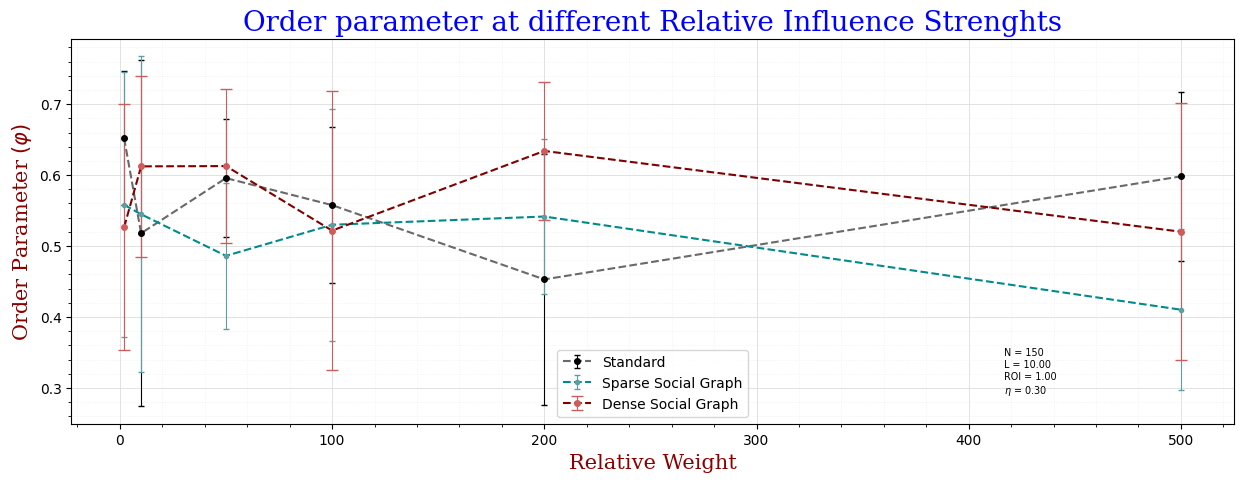

In [12]:
# Displaying the change in the order parameter if we change the strenght of relative interactions

plt.figure(figsize=(15,5))
plt.errorbar(relative_weights, opr_0, yerr=opr_0_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.8, capsize=2, color = "dimgray", mec = 'black', ecolor="black", mfc = 'black', label = "Standard")
plt.errorbar(relative_weights, opr_sparse, yerr=opr_sparse_std, marker = "o", ls = "--",  elinewidth=0.8, capsize=2, markersize = 3, ecolor = 'cadetblue', color = "darkcyan", mec = 'cadetblue', mfc = 'cadetblue', label = "Sparse Social Graph")
plt.errorbar(relative_weights, opr_dense, yerr=opr_dense_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.8, capsize=4, ecolor="indianred", color = "maroon", mec = 'indianred', mfc = 'indianred', label = "Dense Social Graph")
plt.legend()
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title("Order parameter at different Relative Influence Strenghts", fontdict=font1)
plt.xlabel("Relative Weight", fontdict=font2)
plt.ylabel("Order Parameter $(\\varphi)$", fontdict=font2)
plt.annotate('\n N = %d \n L = %.2f \n ROI = %.2f \n $\eta$ = %.2f ' % (N, L, r, 0.3), xy=(0.8, 0.08), xycoords='axes fraction', fontsize= 'x-small')

Text(0.5, 0.98, 'Cluster Analysis at Different Relative Influence Strenghts')

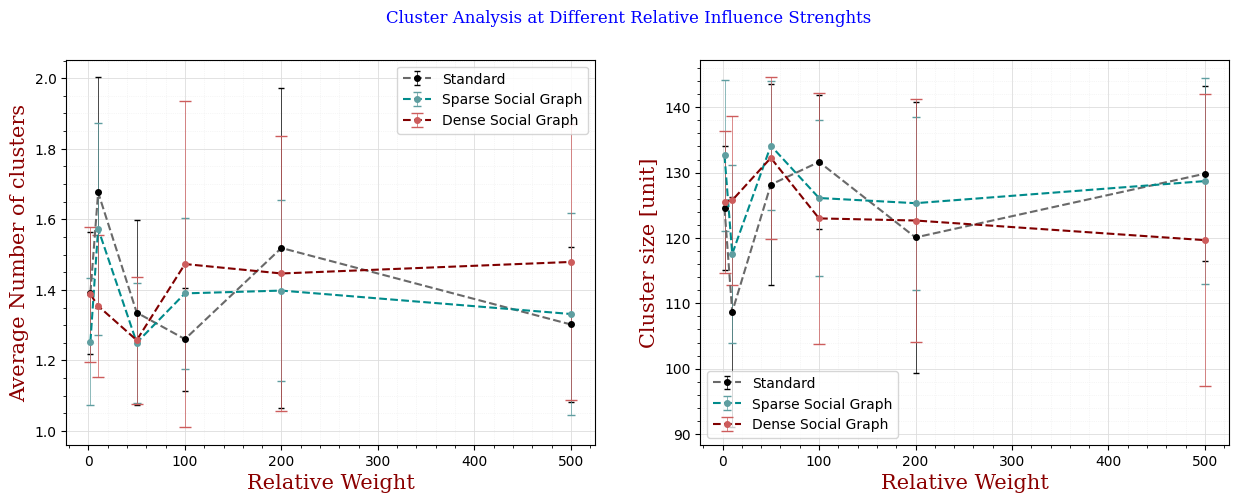

In [13]:
# Displaying the change in the clustering if we change the strenght of relative interactions

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.errorbar(relative_weights, cnr_0, yerr=cnr_0_std, marker = "o", ls = "--",  elinewidth=0.5, capsize=2,  markersize = 4, ecolor="black", color = "dimgray", mec = 'black', mfc = 'black', label = "Standard")
plt.errorbar(relative_weights, cnr_sparse, yerr=cnr_sparse_std, marker = "o",  elinewidth=0.5, capsize=3,  ls = "--", markersize = 4, ecolor="cadetblue", color = "darkcyan", mec = 'cadetblue', mfc = 'cadetblue', label = "Sparse Social Graph")
plt.errorbar(relative_weights, cnr_dense, yerr=cnr_dense_std, marker = "o",  elinewidth=0.5, capsize=4,  ls = "--", markersize = 4, ecolor="indianred", color = "maroon", mec = 'indianred', mfc = 'indianred', label = "Dense Social Graph")
plt.legend()
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.xlabel("Relative Weight", fontdict=font2)
plt.ylabel("Average Number of clusters", fontdict=font2)
plt.subplot(1,2,2)
plt.errorbar(relative_weights, csr_0, yerr=csr_0_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=2, ecolor="black", color = "dimgray", mec = 'black', mfc = 'black', label = "Standard")
plt.errorbar(relative_weights, csr_sparse, yerr=csr_sparse_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=3, ecolor="cadetblue", color = "darkcyan", mec = 'cadetblue', mfc = 'cadetblue', label = "Sparse Social Graph")
plt.errorbar(relative_weights, csr_dense, yerr=csr_desns_std, marker = "o", ls = "--", markersize = 4,  elinewidth=0.5, capsize=4, ecolor="indianred", color = "maroon", mec = 'indianred', mfc = 'indianred', label = "Dense Social Graph")
plt.legend()
plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.xlabel("Relative Weight", fontdict=font2)
plt.ylabel("Cluster size [unit]", fontdict=font2)

fig.suptitle("Cluster Analysis at Different Relative Influence Strenghts", fontdict = font1)

# Simulation for the Animations

In [14]:
ph0_1, ah0_1, op0_1 = Simulation(500, eta[0], positions, angles, relative_weight, relatives0)
ph0_2, ah0_2, op0_2 = Simulation(500, eta[8], positions, angles, relative_weight, relatives0)
ph0_3, ah0_3, op0_3 = Simulation(500, eta[-1], positions, angles, relative_weight, relatives0)

phsparse_1, ahsparse_1, opsparse_1 = Simulation(500, eta[0], positions, angles, relative_weight, relatives_parse)
phsparse_2, ahsparse_2, opsparse_2 = Simulation(500, eta[8], positions, angles, relative_weight, relatives_parse)
phsparse_3, ahsparse_3, opsparse_3 = Simulation(500, eta[-1], positions, angles, relative_weight, relatives_parse)

phdense_1, ahdense_1, opdense_1 = Simulation(500, eta[0], positions, angles, relative_weight, relatives_dense)
phdense_2, ahdense_2, opdense_2 = Simulation(500, eta[8], positions, angles, relative_weight, relatives_dense)
phdense_3, ahdense_3, opdense_3 = Simulation(500, eta[-1], positions, angles, relative_weight, relatives_dense)

In [14]:
#plt.figure(figsize= (15, 5))
#plt.subplot(1,2,1)
#ClusterPlotter(ph_0[1][0])
#plt.title("Initial State", fontdict= font1)
#plt.subplot(1,2,2)
#ClusterPlotter(ph_0[1][30])
#plt.title("Step 30", fontdict= font1)

# Animations

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


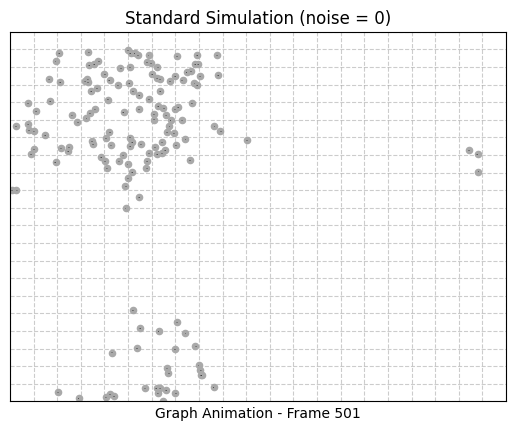

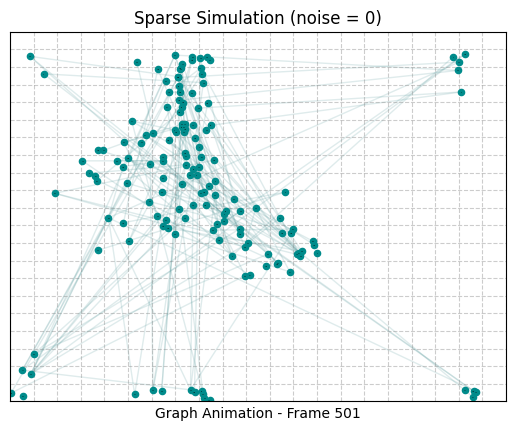

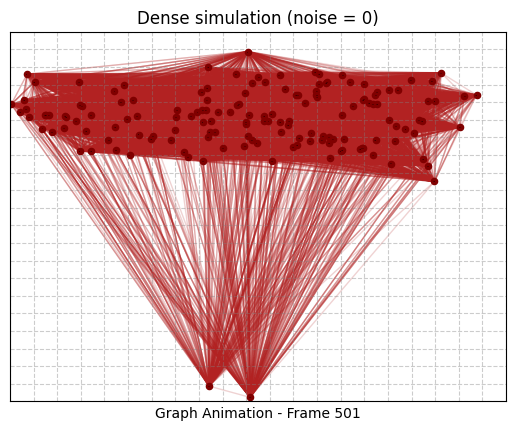

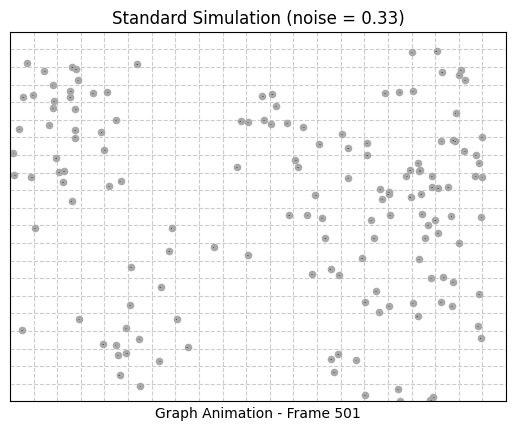

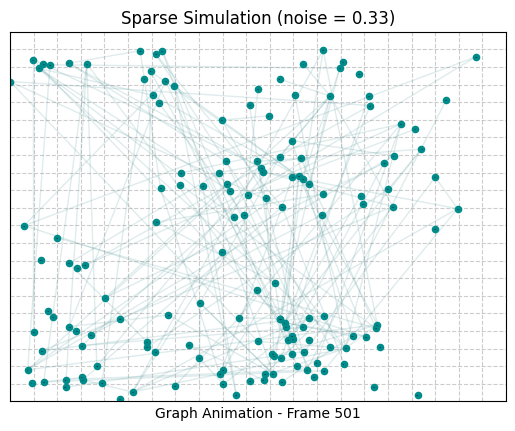

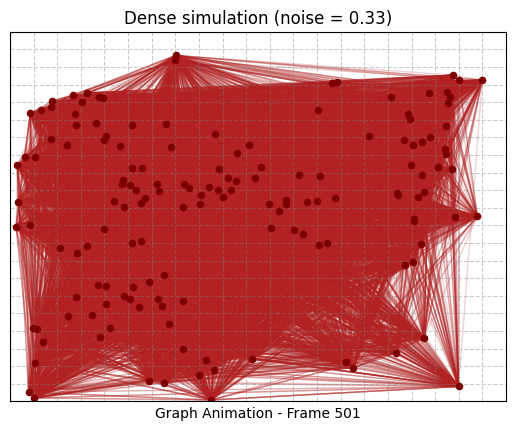

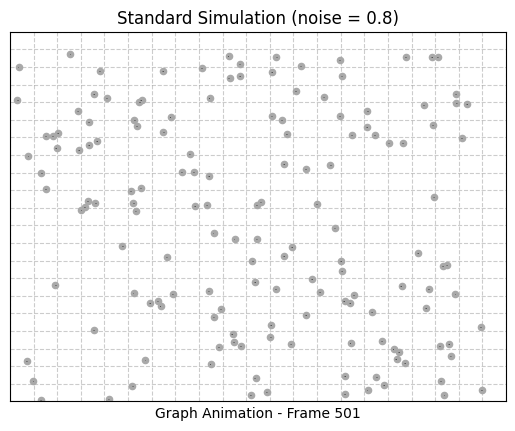

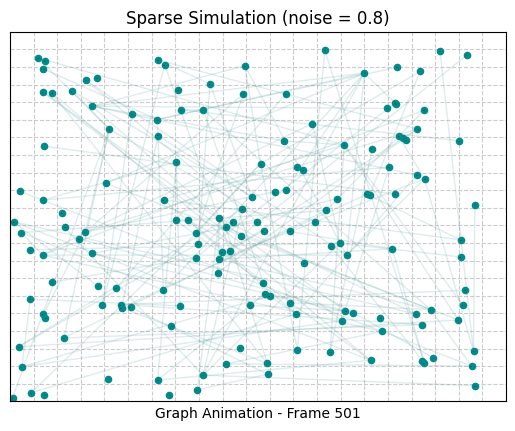

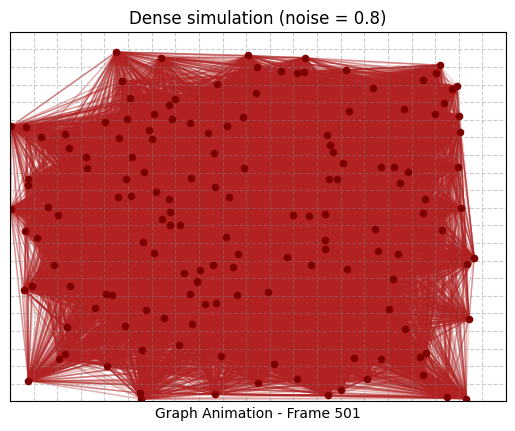

In [15]:
GraphAnimation(social_graph0, ph0_1, "Standard Simulation (noise = 0)", "darkgrey", "darkgrey")
GraphAnimation(social_graph_parse, phsparse_1, "Sparse Simulation (noise = 0)", "darkcyan", "cadetblue")
GraphAnimation(social_graph_dense, phdense_1, "Dense simulation (noise = 0)", "maroon", "firebrick")

GraphAnimation(social_graph0, ph0_2, "Standard Simulation (noise = 0.33)", "darkgrey", "darkgrey")
GraphAnimation(social_graph_parse, phsparse_2, "Sparse Simulation (noise = 0.33)", "darkcyan", "cadetblue")
GraphAnimation(social_graph_dense, phdense_2, "Dense simulation (noise = 0.33)", "maroon", "firebrick")

GraphAnimation(social_graph0, ph0_3, "Standard Simulation (noise = 0.8)", "darkgrey", "darkgrey")
GraphAnimation(social_graph_parse, phsparse_3, "Sparse Simulation (noise = 0.8)", "darkcyan", "cadetblue")
GraphAnimation(social_graph_dense, phdense_3, "Dense simulation (noise = 0.8)", "maroon", "firebrick")